# Lithology Prediction

### Raw Data Exploration

* Show head (6 rows) of raw data
* Color map of lithology over longitude and latitude
* Histogram of lithology
* Missing part visualization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

% matplotlib inline

dfdata = pd.read_csv("data/train_clean.csv")
dfdata.head()

,longitude,latitude,lithology,bathymetry,nitrate,oxygen,phosphate,productivity,salinity,silicate,temperature
0,-180,75,4,-231.0,NaN,8.552258,NaN,310.199677,31.165499,NaN,-0.878415
1,-179,75,4,-203.0,1.702168,9.494461,0.754516,312.468658,29.931450,12.485500,-1.785413
2,-178,75,4,-304.0,1.850258,9.578869,0.735949,291.436279,30.048571,12.902109,-1.904204
3,-177,75,4,-278.0,1.960688,9.668440,0.720070,277.305817,30.211161,13.251008,-1.869162
4,-176,75,4,-247.0,2.056301,9.763065,0.706926,262.947571,30.398439,13.591722,-1.688048


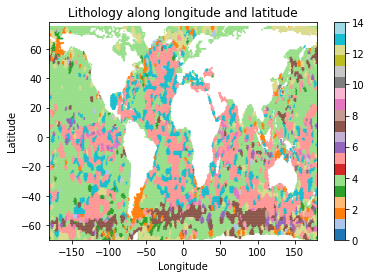

In [2]:
lon = dfdata["longitude"].values
lat = dfdata["latitude"].values
y = dfdata["lithology"].values

# plot lithology vesus longitude and latitude
def draw_global(lon, lat, y, title, cmap="tab20", vmin=0, vmax=14):
    sc = plt.scatter(lon, lat, s=0.5, c=y, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.xlim([-180, 180])
    plt.ylim([-70, 78])
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.colorbar(sc)
    plt.show()
draw_global(lon, lat, y, "Lithology along longitude and latitude")

### Imbalanced Multiclass Classification
As we can see from the histogram of target lithology, the class distribution is not uniform. Some classes have large amount of samples whereas some classes have less samples. This enables model to cost less to predict those rare classes wrong. To fix this problem, we need to re-weight classes to obtain balanced classes.

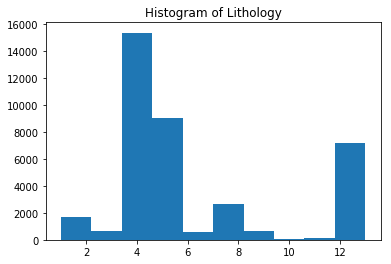

In [3]:
def draw_hist(y, title):
    # plot the histogram of lithology
    plt.hist(y)
    plt.title(title)
    plt.show()

draw_hist(y, "Histogram of Lithology")

### Keras - Neural Network Classification

We will deploy keras - a neural network library which is capable for running on top of Tensorflow.

In [4]:
from keras.layers import Dense, Dropout, Input
from keras.models import Sequential, Model
from keras.callbacks import History
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight
warnings.simplefilter("ignore")

Using Theano backend.


### Data preprocessing
* Normalize features X
* Onehot multiclass target Y

In [5]:
# obtain list of feature names
training_data = dfdata.copy()
target = "lithology"
features = list(training_data.columns)
features.remove(target)
features.remove("longitude")
features.remove("latitude")

# impute missing with mean
fill_dict = {}
for col in training_data:
    fill_dict[col] = np.mean(training_data[col])
training_data = training_data.fillna(value=fill_dict)

# extract X and Y
X = training_data[features].astype(float)
Y = training_data[target]

# standardize X
scaler = StandardScaler()
X = scaler.fit_transform(X)

# onehot target Y -> convert integers to dummy variables
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)
dummy_Y = np_utils.to_categorical(Y)

# class reweighting for imbalanced class
weight = class_weight.compute_class_weight('balanced', np.unique(Y), Y)

### Construct neural network
The neural network has the following structure:
- Input layer
- Hidden layer 1: consists of 64 nerons
- Hidden layer 2: consists of 64 nerons
- Hidden layer 3: consists of 32 nerons
- Output layer

In [6]:
# fix random seed for reproducibility
seed = 0
np.random.seed(seed)

# parameters for hidden layers
activation = "relu"
dropout_ratio = 0.1
initializer = "random_uniform"
numclass = dummy_Y.shape[1]
N, d = X.shape

# construct layers
inputs = Input(shape=(d,))
layer = Dense(64, activation=activation, kernel_initializer=initializer)(inputs)
layer = Dense(64, activation=activation, kernel_initializer=initializer)(layer)
layer = Dense(32, activation=activation, kernel_initializer=initializer)(layer)
prediction = Dense(numclass, activation="softmax")(layer)

# create model
model = Model(inputs=inputs, outputs=prediction)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 13)                429       
Total params: 7,245
Trainable params: 7,245
Non-trainable params: 0
_________________________________________________________________


In [7]:
# shuffle samples
rnd = np.random.RandomState(seed)
shuffle_index = np.arange(N)
rnd.shuffle(shuffle_index)
X = X[shuffle_index]
Y = Y[shuffle_index]
dummy_Y = dummy_Y[shuffle_index]

In [8]:
# parameters for training
epochs = 200
batch_size = 5
verbose = True

# training - 3 fold cross validation
prediction = np.zeros((N, numclass))
kfold = KFold(n_splits=3, random_state=seed)
for train_ind, test_ind in kfold.split(X):
    train_X, train_Y = X[train_ind], dummy_Y[train_ind]
    model.fit(train_X, train_Y, epochs=epochs, batch_size=batch_size, verbose=verbose, class_weight=weight)
    mu = model.predict(X[test_ind])
    prediction[test_ind, :] = mu

Epoch 1/200
25366/25366 [==============================] - 2s 82us/step - loss: 1.4660 - acc: 0.4930
Epoch 2/200
25366/25366 [==============================] - 2s 86us/step - loss: 1.3770 - acc: 0.5276
Epoch 3/200
25366/25366 [==============================] - 2s 86us/step - loss: 1.3543 - acc: 0.5355
Epoch 4/200
25366/25366 [==============================] - 2s 86us/step - loss: 1.3331 - acc: 0.5401
Epoch 5/200
25366/25366 [==============================] - 2s 85us/step - loss: 1.3186 - acc: 0.5440
Epoch 6/200
25366/25366 [==============================] - 2s 85us/step - loss: 1.3027 - acc: 0.5484
Epoch 7/200
25366/25366 [==============================] - 2s 84us/step - loss: 1.2894 - acc: 0.5519
Epoch 8/200
25366/25366 [==============================] - 2s 84us/step - loss: 1.2770 - acc: 0.5553
Epoch 9/200
25366/25366 [==============================] - 2s 85us/step - loss: 1.2648 - acc: 0.5557
Epoch 10/200
25366/25366 [==============================] - 2s 84us/step - loss: 1.2548 - a

25366/25366 [==============================] - 2s 90us/step - loss: 0.9660 - acc: 0.6437
Epoch 82/200
25366/25366 [==============================] - 2s 90us/step - loss: 0.9646 - acc: 0.6426
Epoch 83/200
25366/25366 [==============================] - 2s 90us/step - loss: 0.9612 - acc: 0.6460
Epoch 84/200
25366/25366 [==============================] - 2s 90us/step - loss: 0.9599 - acc: 0.6412
Epoch 85/200
25366/25366 [==============================] - 2s 89us/step - loss: 0.9618 - acc: 0.6439
Epoch 86/200
25366/25366 [==============================] - 2s 90us/step - loss: 0.9543 - acc: 0.6485
Epoch 87/200
25366/25366 [==============================] - 2s 90us/step - loss: 0.9574 - acc: 0.6474
Epoch 88/200
25366/25366 [==============================] - 2s 90us/step - loss: 0.9558 - acc: 0.6461
Epoch 89/200
25366/25366 [==============================] - 2s 89us/step - loss: 0.9501 - acc: 0.6500
Epoch 90/200
25366/25366 [==============================] - 2s 90us/step - loss: 0.9517 - acc: 

25366/25366 [==============================] - 2s 87us/step - loss: 0.8795 - acc: 0.6737
Epoch 161/200
25366/25366 [==============================] - 2s 87us/step - loss: 0.8765 - acc: 0.6750
Epoch 162/200
25366/25366 [==============================] - 2s 87us/step - loss: 0.8805 - acc: 0.6730
Epoch 163/200
25366/25366 [==============================] - 2s 87us/step - loss: 0.8767 - acc: 0.6736
Epoch 164/200
25366/25366 [==============================] - 2s 87us/step - loss: 0.8713 - acc: 0.6754
Epoch 165/200
25366/25366 [==============================] - 2s 87us/step - loss: 0.8741 - acc: 0.6737
Epoch 166/200
25366/25366 [==============================] - 2s 88us/step - loss: 0.8737 - acc: 0.6761
Epoch 167/200
25366/25366 [==============================] - 2s 87us/step - loss: 0.8724 - acc: 0.6723
Epoch 168/200
25366/25366 [==============================] - 2s 88us/step - loss: 0.8772 - acc: 0.6712
Epoch 169/200
25366/25366 [==============================] - 2s 88us/step - loss: 0.868

25366/25366 [==============================] - 2s 88us/step - loss: 0.8761 - acc: 0.6769
Epoch 40/200
25366/25366 [==============================] - 2s 88us/step - loss: 0.8711 - acc: 0.6742
Epoch 41/200
25366/25366 [==============================] - 2s 88us/step - loss: 0.8736 - acc: 0.6755
Epoch 42/200
25366/25366 [==============================] - 2s 88us/step - loss: 0.8728 - acc: 0.6742
Epoch 43/200
25366/25366 [==============================] - 2s 87us/step - loss: 0.8716 - acc: 0.6763
Epoch 44/200
25366/25366 [==============================] - 2s 87us/step - loss: 0.8727 - acc: 0.6766
Epoch 45/200
25366/25366 [==============================] - 2s 87us/step - loss: 0.8698 - acc: 0.6791
Epoch 46/200
25366/25366 [==============================] - 2s 86us/step - loss: 0.8667 - acc: 0.6769
Epoch 47/200
25366/25366 [==============================] - 2s 87us/step - loss: 0.8657 - acc: 0.6813
Epoch 48/200
25366/25366 [==============================] - 2s 87us/step - loss: 0.8716 - acc: 

25366/25366 [==============================] - 2s 87us/step - loss: 0.8293 - acc: 0.6925
Epoch 119/200
25366/25366 [==============================] - 2s 87us/step - loss: 0.8269 - acc: 0.6912
Epoch 120/200
25366/25366 [==============================] - 2s 87us/step - loss: 0.8256 - acc: 0.6916
Epoch 121/200
25366/25366 [==============================] - 2s 86us/step - loss: 0.8307 - acc: 0.6910
Epoch 122/200
25366/25366 [==============================] - 2s 87us/step - loss: 0.8254 - acc: 0.6935
Epoch 123/200
25366/25366 [==============================] - 2s 87us/step - loss: 0.8267 - acc: 0.6918
Epoch 124/200
25366/25366 [==============================] - 2s 87us/step - loss: 0.8273 - acc: 0.6947
Epoch 125/200
25366/25366 [==============================] - 2s 87us/step - loss: 0.8248 - acc: 0.6929
Epoch 126/200
25366/25366 [==============================] - 2s 87us/step - loss: 0.8285 - acc: 0.6936
Epoch 127/200
25366/25366 [==============================] - 2s 86us/step - loss: 0.832

Epoch 197/200
25366/25366 [==============================] - 2s 87us/step - loss: 0.8048 - acc: 0.7023
Epoch 198/200
25366/25366 [==============================] - 2s 87us/step - loss: 0.8096 - acc: 0.6992
Epoch 199/200
25366/25366 [==============================] - 2s 87us/step - loss: 0.8100 - acc: 0.6981
Epoch 200/200
25366/25366 [==============================] - 2s 87us/step - loss: 0.8054 - acc: 0.7015
Epoch 1/200
25366/25366 [==============================] - 2s 89us/step - loss: 0.9229 - acc: 0.6722
Epoch 2/200
25366/25366 [==============================] - 2s 86us/step - loss: 0.9100 - acc: 0.6733
Epoch 3/200
25366/25366 [==============================] - 2s 86us/step - loss: 0.8970 - acc: 0.6741
Epoch 4/200
25366/25366 [==============================] - 2s 86us/step - loss: 0.8900 - acc: 0.6775
Epoch 5/200
25366/25366 [==============================] - 2s 86us/step - loss: 0.8902 - acc: 0.6781
Epoch 6/200
25366/25366 [==============================] - 2s 87us/step - loss: 0.8

25366/25366 [==============================] - 2s 85us/step - loss: 0.8207 - acc: 0.6977
Epoch 78/200
25366/25366 [==============================] - 2s 86us/step - loss: 0.8263 - acc: 0.6968: 1s - loss
Epoch 79/200
25366/25366 [==============================] - 2s 86us/step - loss: 0.8201 - acc: 0.6985
Epoch 80/200
25366/25366 [==============================] - 2s 86us/step - loss: 0.8254 - acc: 0.6982
Epoch 81/200
25366/25366 [==============================] - 2s 86us/step - loss: 0.8191 - acc: 0.6980
Epoch 82/200
25366/25366 [==============================] - 2s 86us/step - loss: 0.8272 - acc: 0.6940
Epoch 83/200
25366/25366 [==============================] - 2s 86us/step - loss: 0.8209 - acc: 0.6974
Epoch 84/200
25366/25366 [==============================] - 2s 85us/step - loss: 0.8191 - acc: 0.6993
Epoch 85/200
25366/25366 [==============================] - 2s 85us/step - loss: 0.8222 - acc: 0.6952: 0s - loss: 0.8171 - acc: 0
Epoch 86/200
25366/25366 [==============================

25366/25366 [==============================] - 2s 85us/step - loss: 0.7950 - acc: 0.7067
Epoch 157/200
25366/25366 [==============================] - 2s 85us/step - loss: 0.7903 - acc: 0.7086
Epoch 158/200
25366/25366 [==============================] - 2s 85us/step - loss: 0.8019 - acc: 0.7067
Epoch 159/200
25366/25366 [==============================] - 2s 85us/step - loss: 0.7916 - acc: 0.7064
Epoch 160/200
25366/25366 [==============================] - 2s 85us/step - loss: 0.8088 - acc: 0.7015
Epoch 161/200
25366/25366 [==============================] - 2s 85us/step - loss: 0.7931 - acc: 0.7050
Epoch 162/200
25366/25366 [==============================] - 2s 85us/step - loss: 0.8001 - acc: 0.7042
Epoch 163/200
25366/25366 [==============================] - 2s 85us/step - loss: 0.7986 - acc: 0.7059
Epoch 164/200
25366/25366 [==============================] - 2s 85us/step - loss: 0.7910 - acc: 0.7085
Epoch 165/200
25366/25366 [==============================] - 2s 84us/step - loss: 0.793

### Validate

Accuracy = 0.6512129096691108


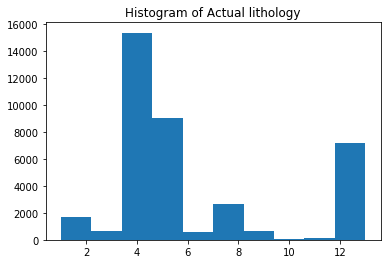

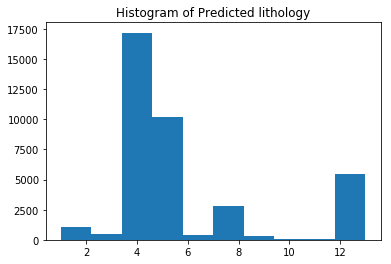

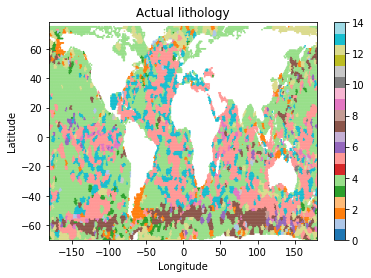

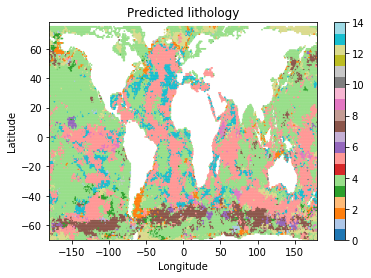

In [9]:
lon = dfdata["longitude"].values[shuffle_index]
lat = dfdata["latitude"].values[shuffle_index]

mean = np.argmax(prediction, axis=1)
print("Accuracy = {}".format(accuracy_score(Y, mean)))
draw_hist(Y + 1, "Histogram of Actual lithology")
draw_hist(mean + 1, "Histogram of Predicted lithology")
draw_global(lon, lat, Y + 1, "Actual lithology")
draw_global(lon, lat, mean + 1, "Predicted lithology")

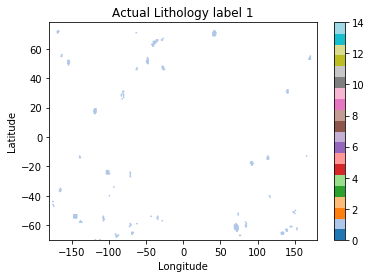

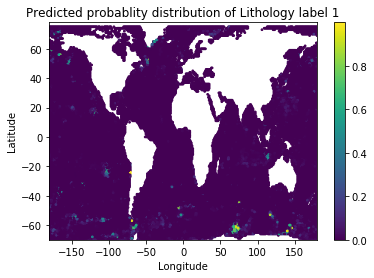

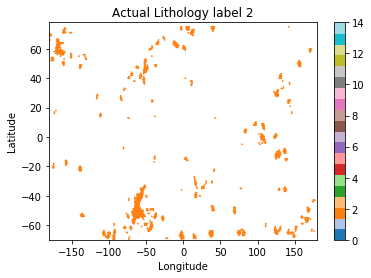

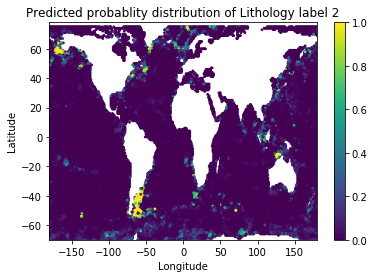

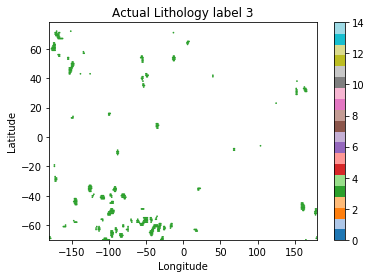

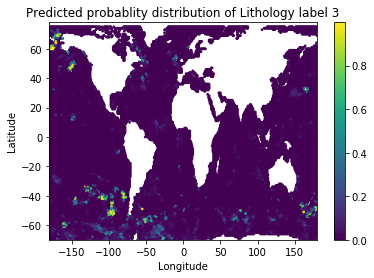

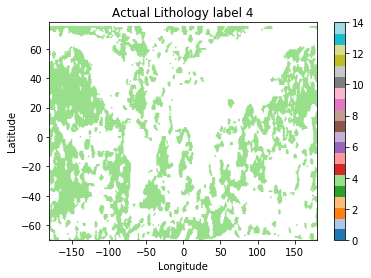

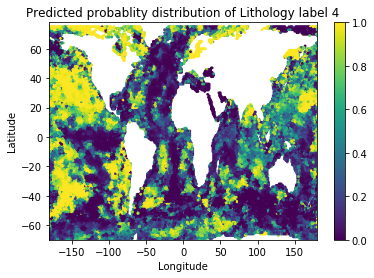

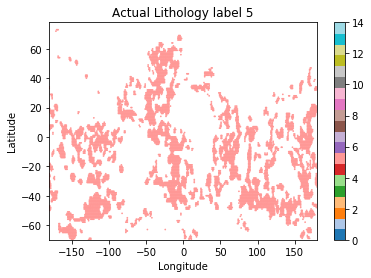

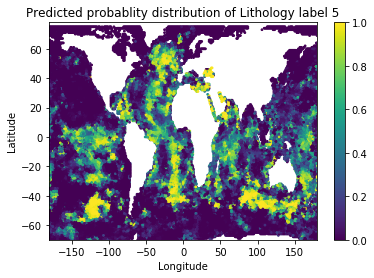

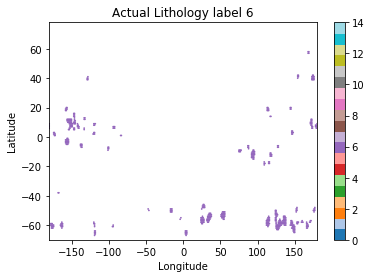

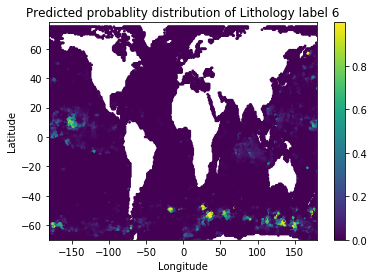

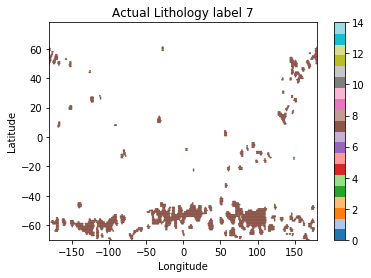

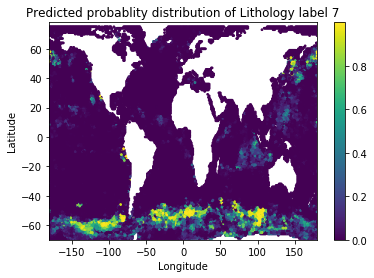

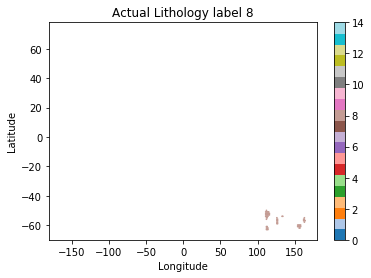

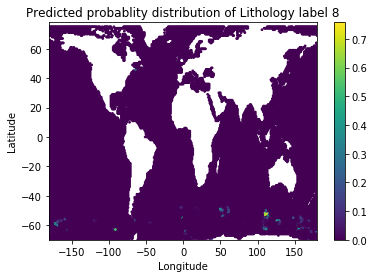

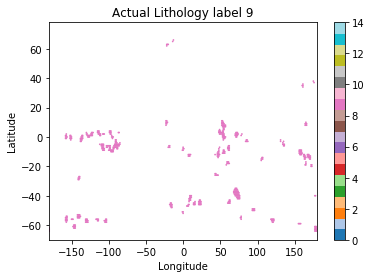

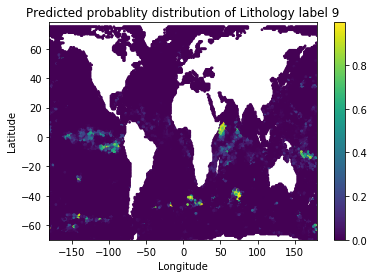

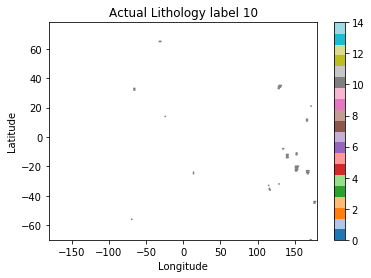

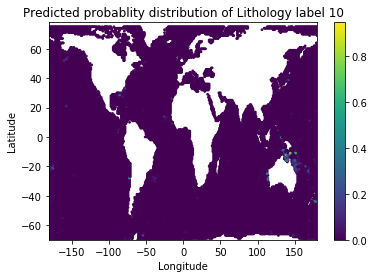

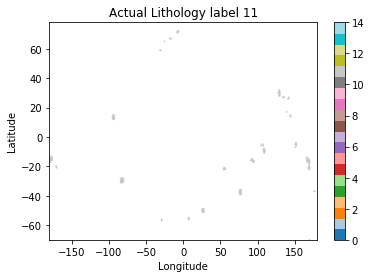

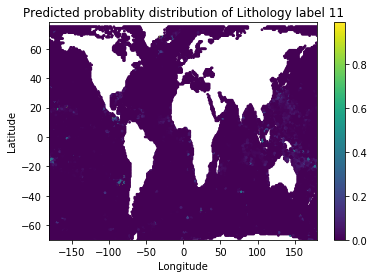

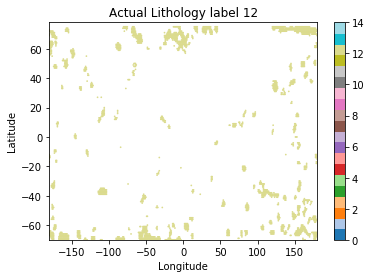

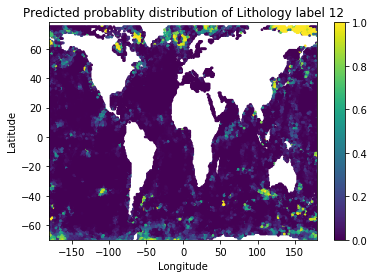

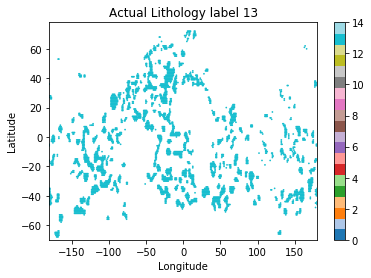

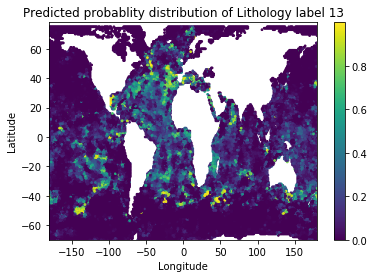

In [10]:
def draw_prob(lon, lat, p, title, size=3):
    sc = plt.scatter(lon, lat, s=size, c=p)
    plt.title(title)
    plt.xlim([-180, 180])
    plt.ylim([-70, 78])
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.colorbar(sc)
    plt.show()
    plt.close()
    
for i in range(13):
    common_part = "Lithology label {}".format(i + 1)
    title_p = "Predicted probablity distribution of {}".format(common_part)
    title_y = "Actual {}".format(common_part)
    # find Y_ts whose label is i + 1 and plot
    index = Y == i
    thisY = Y[Y == i] + 1
    draw_global(lon[index], lat[index], y=thisY, title=title_y)
    # plot prob distribution
    draw_prob(lon, lat, p = prediction[:,i], title=title_p)